In [1]:
# import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import metrics, preprocessing
import seaborn as sns
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")

## Load dataset

In [2]:
#read data
data = pd.read_excel('default of credit card clients.xls')
data.head()
data.shape

(30001, 25)

**Information**

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:<br>
X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.<br>
X2: Gender (1 = male; 2 = female).<br>
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).<br>
X4: Marital status (1 = married; 2 = single; 3 = others).<br>
X5: Age (year).<br>
X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.<br>
X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. <br>
X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.



## Preprocess

### Convert Datatype from Object to Int

In [3]:
data=data.drop([0])

In [4]:
df = data.astype(int)
df.dtypes

Unnamed: 0    int64
X1            int64
X2            int64
X3            int64
X4            int64
X5            int64
X6            int64
X7            int64
X8            int64
X9            int64
X10           int64
X11           int64
X12           int64
X13           int64
X14           int64
X15           int64
X16           int64
X17           int64
X18           int64
X19           int64
X20           int64
X21           int64
X22           int64
X23           int64
Y             int64
dtype: object

In [5]:
df = df.drop(columns='Unnamed: 0')

### Delete Outliers

In [6]:
df["X6"][df.X6<1]=-1
df["X7"][df.X7<1]=-1
df["X8"][df.X8<1]=-1
df["X9"][df.X9<1]=-1
df["X10"][df.X10<1]=-1
df["X11"][df.X11<1]=-1

In [7]:
df.shape

(30000, 24)

## Explore Dataset 

### Correlation Coefficients to default

In [8]:
df.corr()['Y'] #Show the correlation Coefficients to default

X1    -0.153520
X2    -0.039961
X3     0.028006
X4    -0.024339
X5     0.013890
X6     0.398636
X7     0.333438
X8     0.292026
X9     0.274779
X10    0.266465
X11    0.248252
X12   -0.019644
X13   -0.014193
X14   -0.014076
X15   -0.010156
X16   -0.006760
X17   -0.005372
X18   -0.072929
X19   -0.058579
X20   -0.056250
X21   -0.056827
X22   -0.055124
X23   -0.053183
Y      1.000000
Name: Y, dtype: float64

<AxesSubplot:>

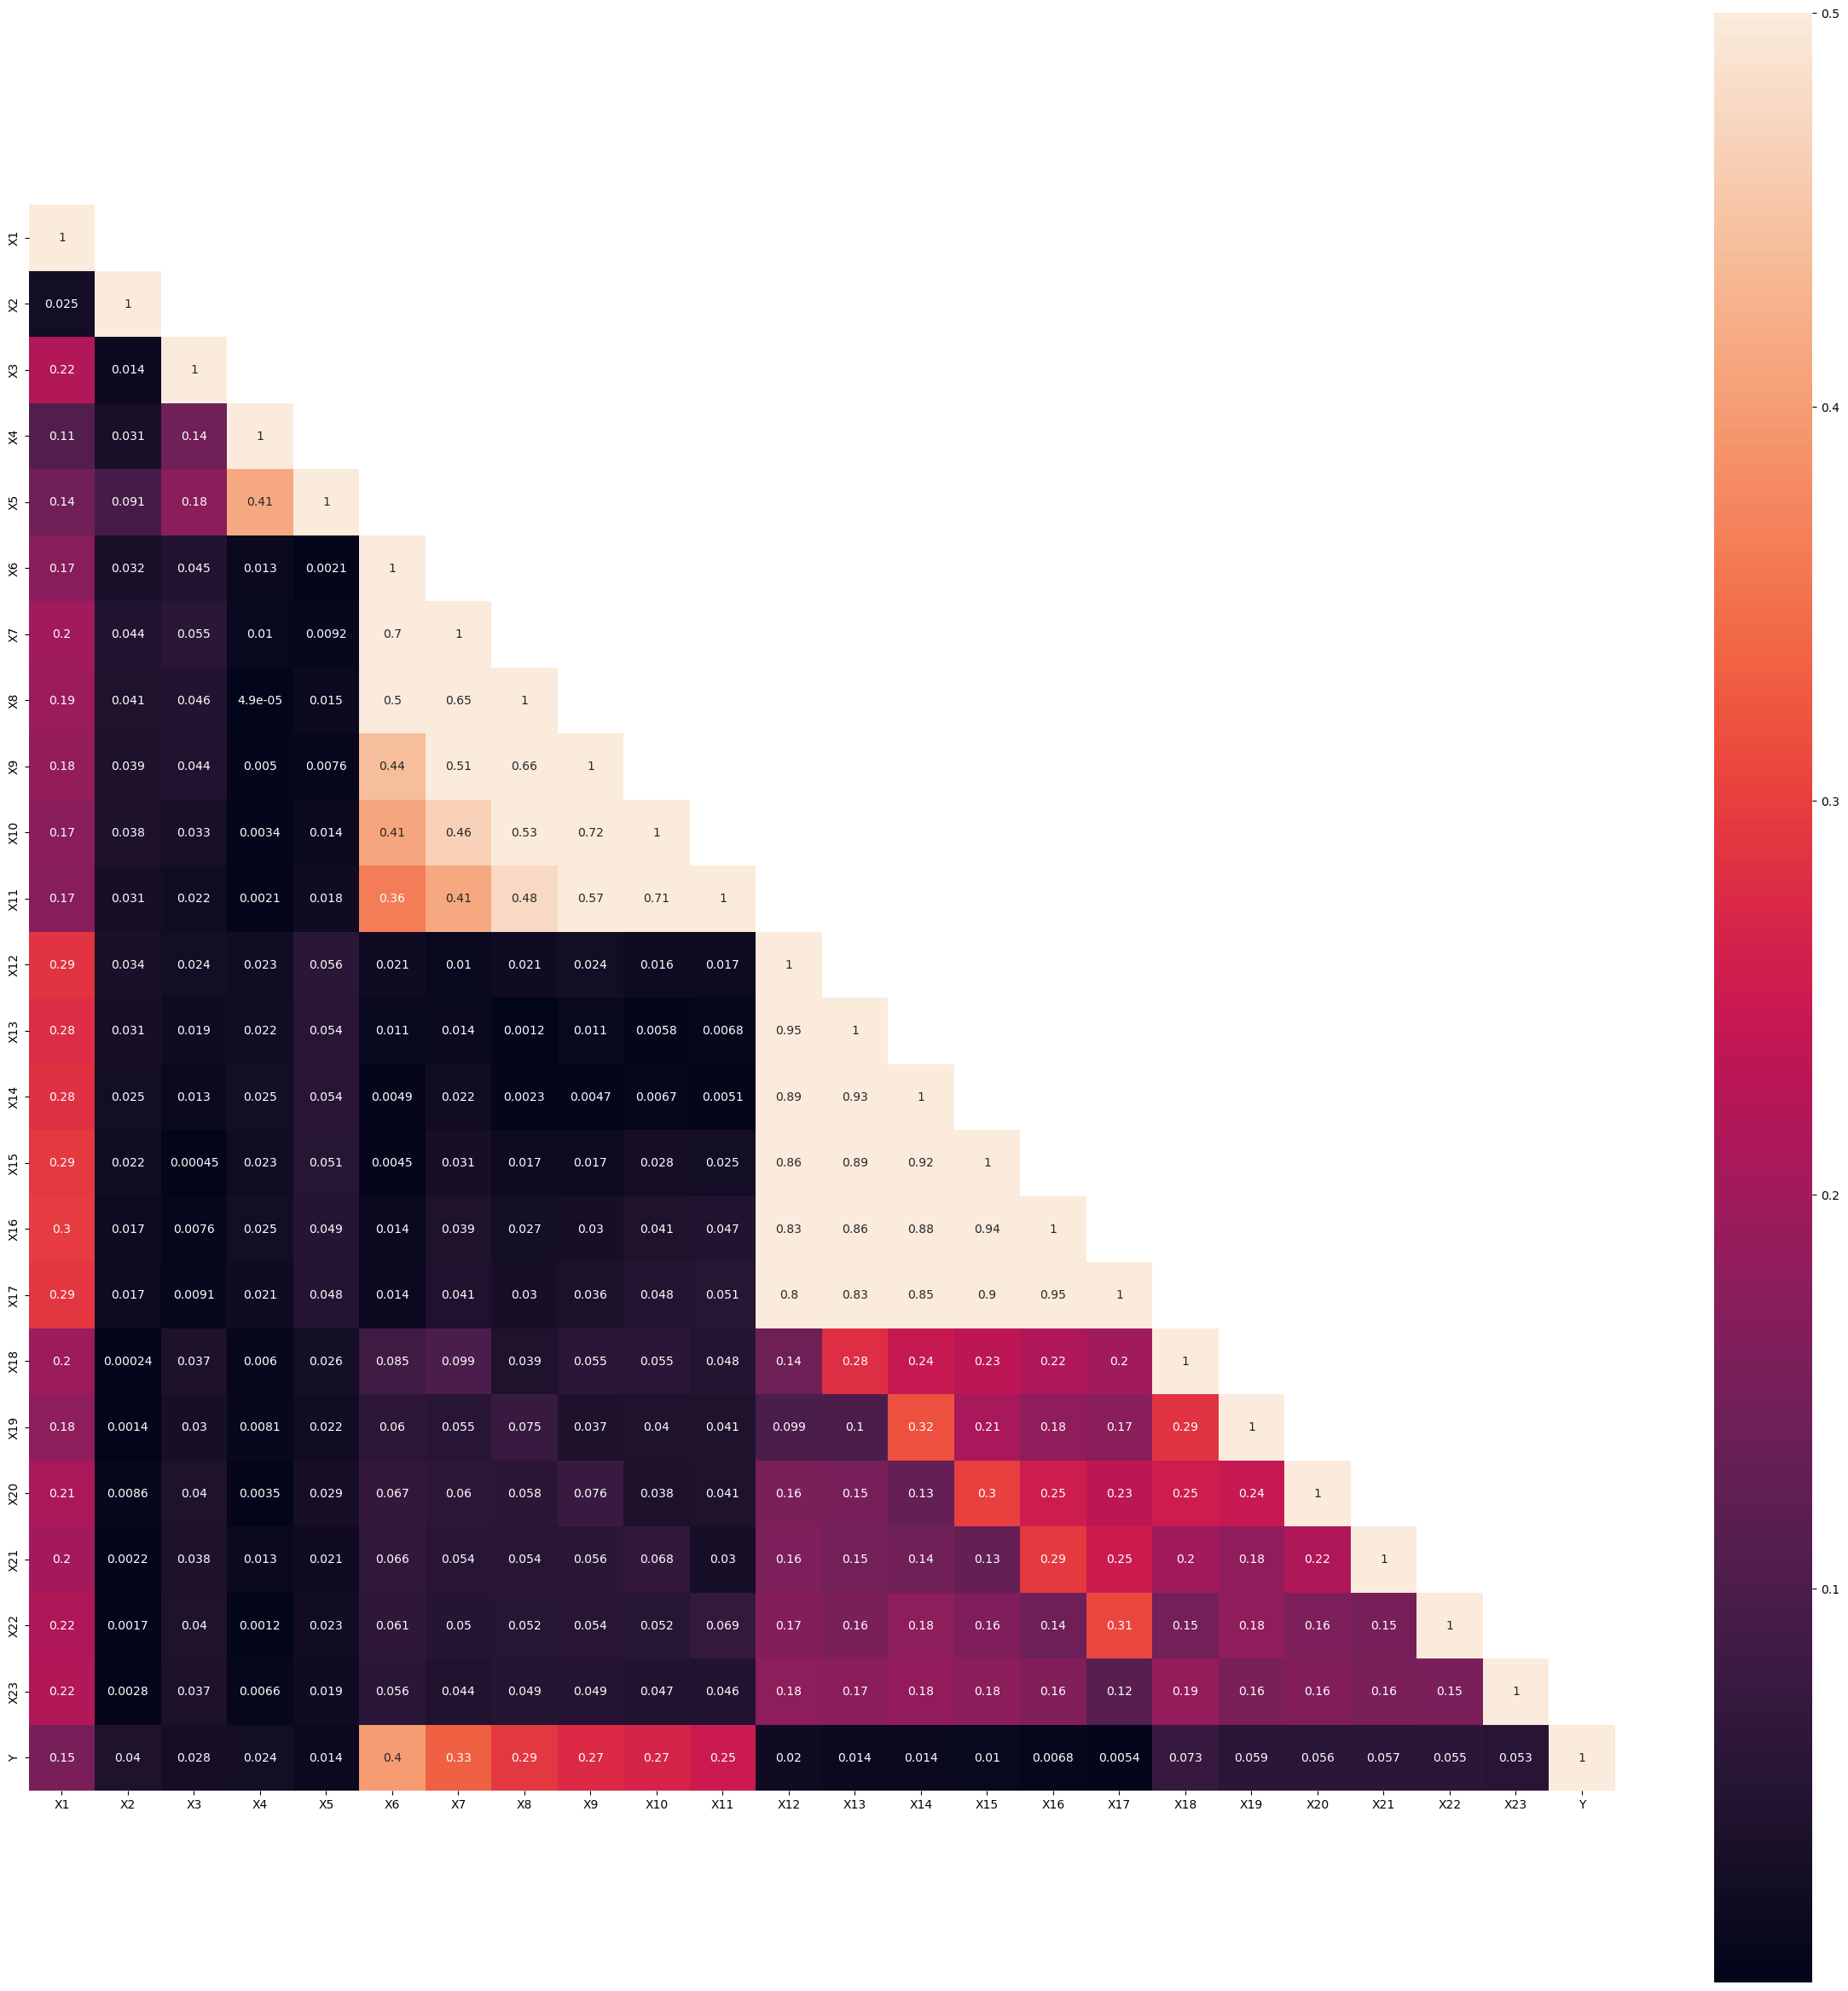

In [9]:
corr_matrix = df.corr().abs()
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(30,30)
sns.heatmap(corr_matrix,mask=mask,vmax=.5,  square=True,annot=True)

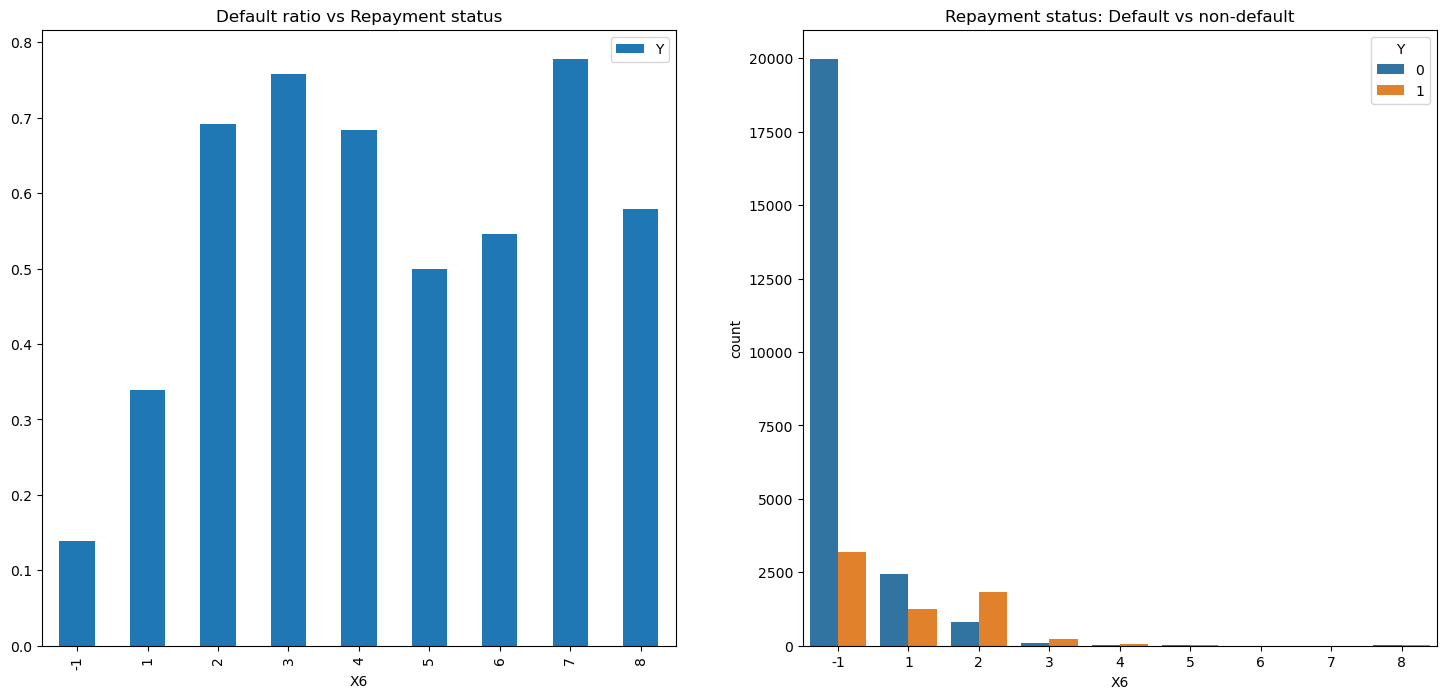

In [10]:
# Show default with grades
f,ax=plt.subplots(1,2,figsize=(18,8))
df[['X6','Y']].groupby(['X6']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Default ratio vs Repayment status')
sns.countplot(x= 'X6',hue='Y',data= df,ax=ax[1])
ax[1].set_title('Repayment status: Default vs non-default')
plt.show()

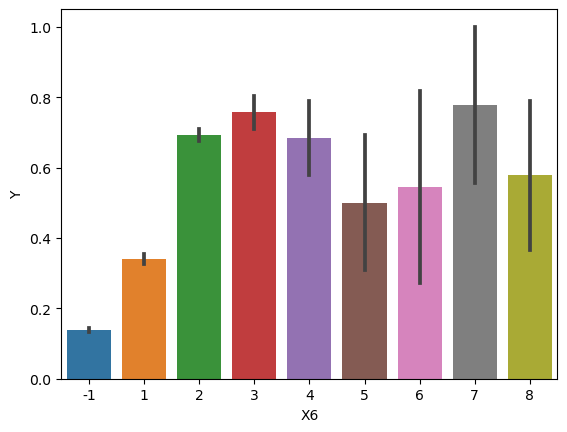

In [11]:
# Show the default ratio of different grades
grade_order=[-1,1,2,3,4,5,6,7,8]
sns.barplot(x='X6',y='Y',data=df,order=grade_order)
plt.show()

## Standardization

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
# conda install -c conda-forge hdf5=1.10.5

In [14]:
from sklearn.neural_network import MLPClassifier

In [15]:
# Divide the whole data to 2 parts, 80% as training set, 20% as test set
train,test=train_test_split(df,test_size=0.2,random_state=0,stratify=df['Y'])

train_X=train[train.columns[:-1]]
train_y=train[train.columns[-1]]

test_X=test[test.columns[:-1]]
test_y=test[test.columns[-1]]

In [16]:
scaler = StandardScaler()
train_X = pd.DataFrame(scaler.fit_transform(train_X), columns=train_X.columns)
test_X = pd.DataFrame(scaler.fit_transform(test_X), columns=test_X.columns)


In [17]:
train_X

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,1.181870,-1.240623,-1.079839,0.858477,-1.029674,-0.512063,-0.409703,-0.395840,-0.353658,-0.323191,...,-0.478122,-0.486032,-0.666427,-0.656171,-0.264078,-0.181775,-0.296122,-0.311500,-0.312013,12.249169
1,0.252354,-1.240623,-1.079839,-1.060800,0.494083,-0.512063,-0.409703,-0.395840,-0.353658,-0.323191,...,-0.586932,-0.634081,-0.569042,-0.030126,-0.041420,0.050646,-0.153340,0.077286,0.839939,-0.017405
2,-0.367323,0.806047,-1.079839,0.858477,1.038281,-0.512063,-0.409703,-0.395840,-0.353658,-0.323191,...,0.587722,0.722846,0.909079,0.987761,-0.156202,-0.117812,-0.115437,0.155043,-0.077757,-0.075234
3,-1.141920,0.806047,-1.079839,0.858477,-1.465033,-0.512063,-0.409703,-0.395840,-0.353658,-0.323191,...,-0.665491,-0.670154,-0.666427,-0.651072,-0.339508,-0.215673,-0.292458,-0.311500,-0.292362,0.140115
4,-1.064461,0.806047,1.450909,-1.060800,0.711762,-0.512063,-0.409703,-0.395840,-0.353658,-0.323191,...,-0.485926,-0.634517,-0.169698,-0.164117,-0.257886,-0.202881,-0.250651,1.632431,-0.243949,-0.218382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,-0.677162,0.806047,0.185535,-1.060800,0.167563,-0.512063,-0.409703,-0.395840,-0.353658,-0.323191,...,-0.042160,0.033160,0.137064,0.186146,-0.041836,-0.125780,-0.190582,-0.052310,-0.181871,-0.183593
23996,-0.057485,0.806047,0.185535,-1.060800,-0.267796,-0.512063,-0.409703,-0.395840,-0.353658,-0.323191,...,-0.539935,0.143967,-0.545389,-0.618862,-0.193470,0.170560,2.847194,-0.211323,-0.168206,-0.297655
23997,-0.599703,0.806047,0.185535,-1.060800,1.255961,-0.512063,-0.409703,-0.395840,-0.353658,-0.323191,...,-0.263151,-0.227129,-0.184834,-0.158968,-0.220439,-0.168853,-0.190582,-0.181905,-0.181871,-0.183593
23998,-0.909541,0.806047,0.185535,0.858477,-0.703155,1.236090,2.197332,2.258332,2.451911,-0.323191,...,0.028263,0.073175,0.142973,0.154696,-0.339508,-0.061171,-0.310719,-0.198040,-0.199050,-0.128216


In [18]:
train_y

6671     0
12887    1
16219    0
5773     0
22647    1
        ..
25589    0
258      0
8604     0
12913    1
20374    1
Name: Y, Length: 24000, dtype: int64

## SVM ( Support Vector Machine)

 In this model, we plot each data item as a **unique point** in an n-dimension,(where n is the number of features that we have), with the value of each of the features being the value of that particular coordinate. Then, we perform the process of classification by finding the **hyper-plane** that differentiates the two classes.

In [16]:
from sklearn import svm

In [17]:
clf = svm.SVC(kernel = 'rbf',class_weight='balanced')
clf.fit(train_X,train_y)
prediction=clf.predict(test_X)
print("The prediction values are: ",prediction)
print('The f1_score of the SVM is',f1_score(prediction,test_y,average='weighted'))

The prediction values are:  [1 0 0 ... 0 0 1]
The f1_score of the SVM is 0.5318318651212119


**Comments**: SVM performs worst.

## Nueral network (Fully connected)

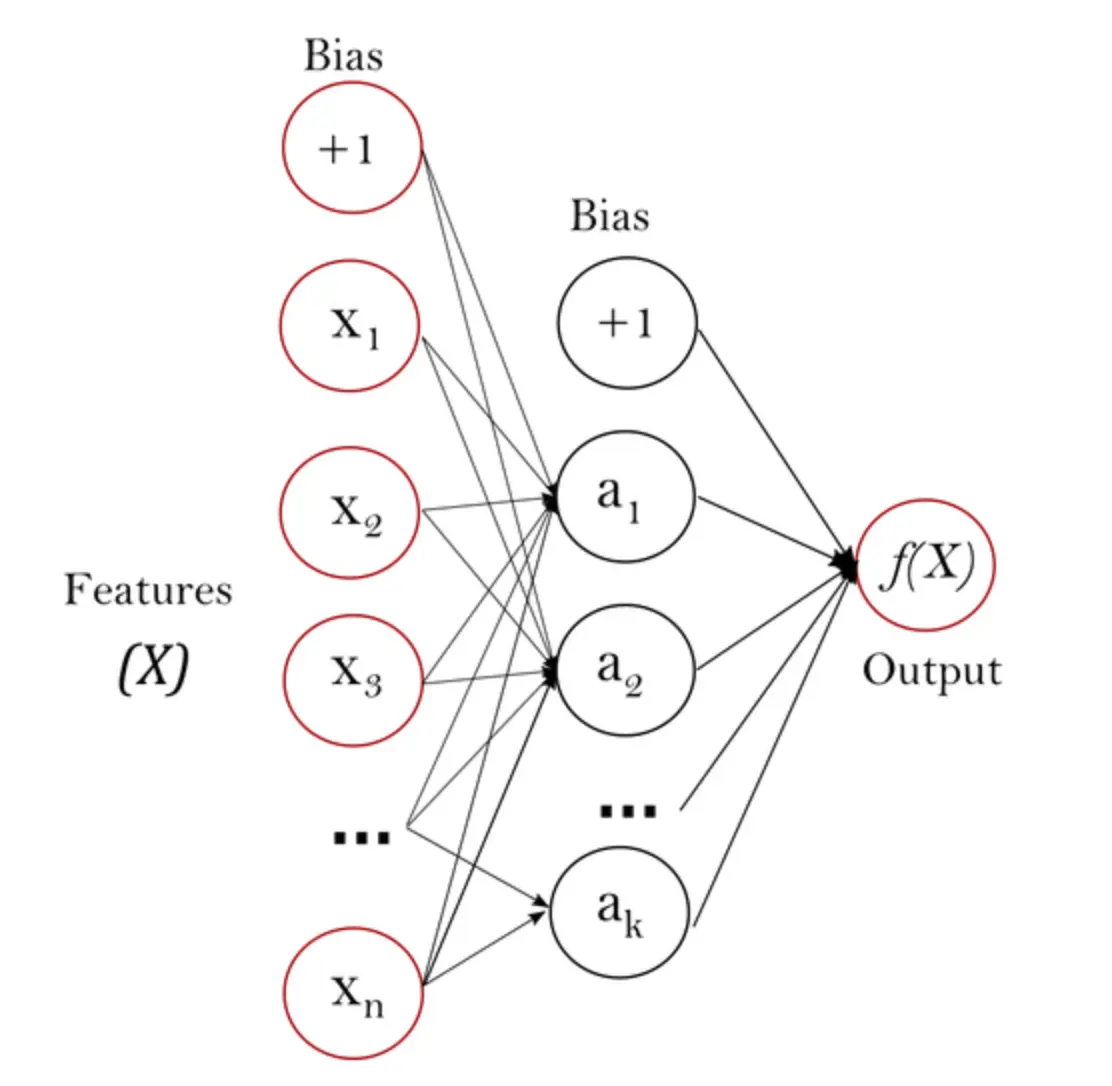

### Choose activation function

- identity：f(x) = x 

- logistic: sigmod, f(x) = 1 / (1 + exp(-x)). 

- tanh：f(x) = tanh(x). 

- relu：f(x) = max(0, x) 



In [18]:
activation=['identity','logistic','tanh','relu']
for act in activation:
    clf = MLPClassifier(activation = str(act),max_iter = 100,alpha = 1e-5,hidden_layer_sizes = (100,),random_state = 1)
    clf.fit(train_X,train_y)
    prediction=clf.predict(test_X)
    #clf.get_params([clf])
    print("The prediction values are: ",prediction)
    print('The f1_score of ',str(act),' is',f1_score(prediction,test_y,average='weighted'))


The prediction values are:  [1 1 0 ... 1 1 1]
The f1_score of  identity  is 0.35964649768317714
The prediction values are:  [0 0 0 ... 0 0 0]
The f1_score of  logistic  is 0.8756675723789
The prediction values are:  [0 0 0 ... 0 0 0]
The f1_score of  tanh  is 0.874662542568813
The prediction values are:  [0 0 0 ... 0 0 0]
The f1_score of  relu  is 0.8649040700808626


**Comments**: identity activation works best.

### Choose solver (the method to optimize the weight)

- lbfgs: optimizer for the quasi-Newton method

- sgd: stochastic gradient descent

- adam: Opportunistic stochastic gradient optimizer proposed by Kingma, Diederik, and Jimmy Ba

NOTE: The default solver "adam" works well both in terms of training time and validation scores on relatively large datasets (thousands of training samples or more). However, for small datasets, "lbfgs" can converge faster and perform better.

In [22]:
solver=['lbfgs','sgd','adam']
for s in solver:
    clf = MLPClassifier(solver=str(s),activation = 'identity',max_iter = 100,alpha = 1e-5,hidden_layer_sizes = (100,),random_state = 1)
    clf.fit(train_X,train_y)
    prediction=clf.predict(test_X)
    print("The prediction values are: ",prediction)
    print('The f1_score of ',str(s),' is',f1_score(prediction,test_y,average='weighted'))

The prediction values are:  [0 0 0 ... 0 0 0]
The f1_score of  lbfgs  is 0.8433389845244526
The prediction values are:  [0 0 0 ... 0 0 0]
The f1_score of  sgd  is 0.8441712541938705
The prediction values are:  [0 0 0 ... 0 0 0]
The f1_score of  adam  is 0.8461579747837679


**Comments**: adam works best

### Choose hidden layer size

- Number of layers

- Number of neurons in each layer


 There's a rule of thumb that helps for supervised learning problems. We can usually prevent over-fitting if we keep our number of neurons below:
 
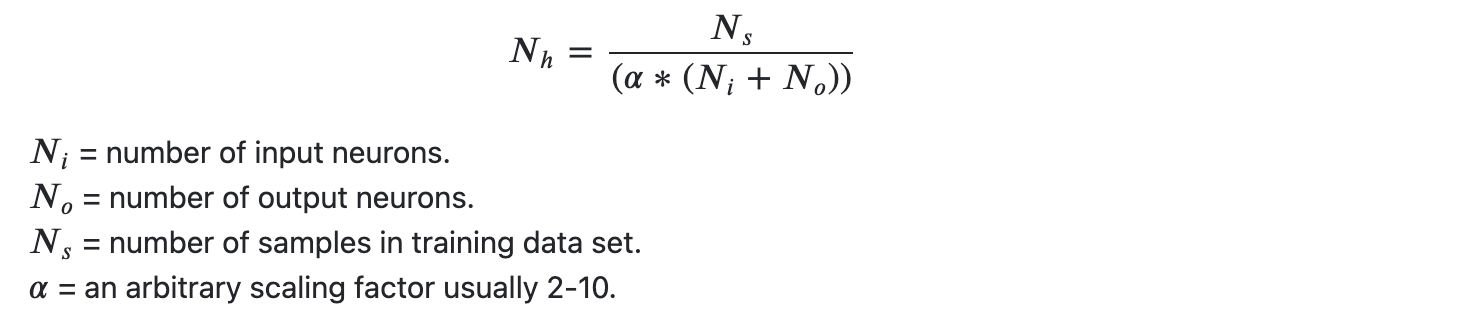

In this case, Ni=23(X), No=2(default or not), Ns=24000 
Nh=96~480

### 1 hidden layer

In [23]:
neurons=range(20,200,5)
f1_scores=[]
N=[]
for n in neurons:
    clf = MLPClassifier(solver='adam',activation = 'identity',max_iter = 100,alpha = 1e-5,hidden_layer_sizes = (int(n),),random_state = 1)
    clf.fit(train_X,train_y)
    prediction=clf.predict(test_X)
    N.append(n)
    f1_scores.append(f1_score(prediction,test_y,average='weighted'))
    #print("The prediction values are: ",prediction)
    #print('The f1_score of ',str(s),' is',f1_score(prediction,test_y,average='weighted'))

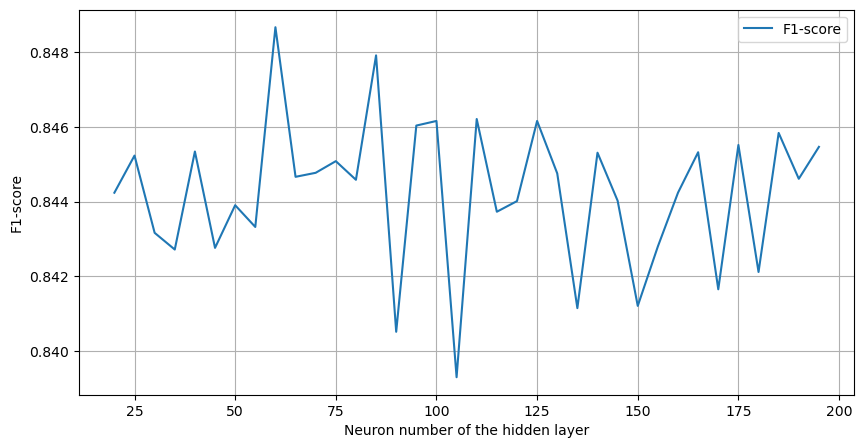

In [24]:
fig2=plt.figure(figsize=(10, 5))
x = N
plt.plot(x,f1_scores, label = 'F1-score')

#plt.xscale('symlog')
plt.xlabel('Neuron number of the hidden layer')
plt.ylabel('F1-score')

plt.grid()
plt.legend()

### 2 hidden layers

In [25]:
neurons=range(20,200,5)
f1_scores=[]
N=[]
for n in neurons:
    clf = MLPClassifier(solver='adam',activation = 'identity',max_iter = 100,alpha = 1e-5,hidden_layer_sizes = (int(n),int(n),),random_state = 1)
    clf.fit(train_X,train_y)
    prediction=clf.predict(test_X)
    N.append(n)
    f1_scores.append(f1_score(prediction,test_y,average='weighted'))
    #print("The prediction values are: ",prediction)
    #print('The f1_score of ',str(s),' is',f1_score(prediction,test_y,average='weighted'))

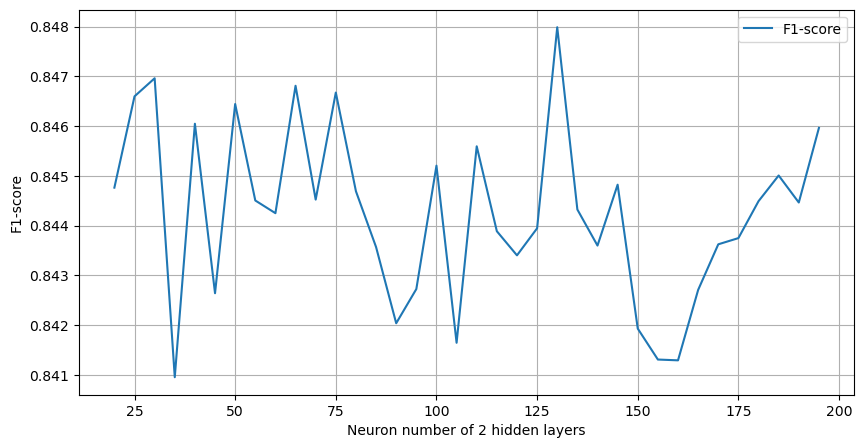

In [26]:
fig2=plt.figure(figsize=(10, 5))
x = N
plt.plot(x,f1_scores, label = 'F1-score')

#plt.xscale('symlog')
plt.xlabel('Neuron number of 2 hidden layers')
plt.ylabel('F1-score')

plt.grid()
plt.legend()

### 3 hidden layers with different neurons

In [27]:
neurons=range(10,90,2)
f1_scores=[]
N=[]
for n in neurons:
    clf = MLPClassifier(solver='adam',activation = 'identity',max_iter = 100,alpha = 1e-5,hidden_layer_sizes = (100,int(n),100),random_state = 1)
    clf.fit(train_X,train_y)
    prediction=clf.predict(test_X)
    N.append(n)
    f1_scores.append(f1_score(prediction,test_y,average='weighted'))
    #print("The prediction values are: ",prediction)
    #print('The f1_score of ',str(s),' is',f1_score(prediction,test_y,average='weighted'))

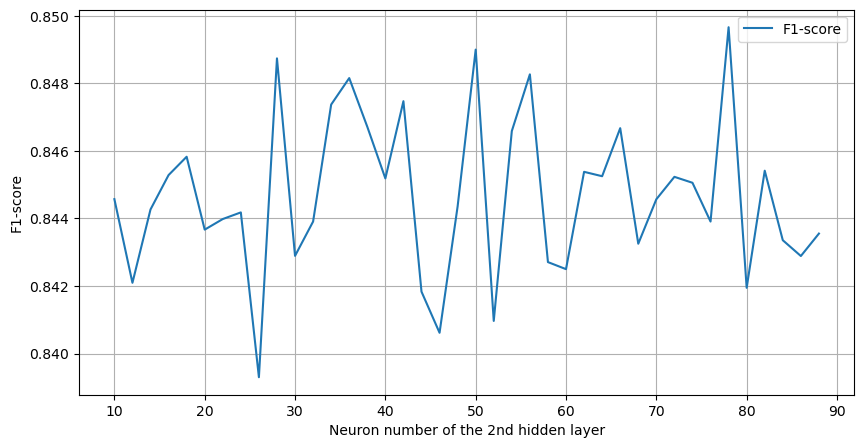

In [28]:
fig2=plt.figure(figsize=(10, 5))
x = N
plt.plot(x,f1_scores, label = 'F1-score')

#plt.xscale('symlog')
plt.xlabel('Neuron number of the 2nd hidden layer')
plt.ylabel('F1-score')

plt.grid()
plt.legend()